# Tarea 3 - CNN
Integrantes: 
- Matías Aguilera
- Jonas Oviedo
- Natalia Romero

## Introducción
El objetivo de esta tarea es desarrollar un modelo de Convolutional Neural Network (CNN) que pueda predecir la presencia de COVID-19 a partir de grabaciones de tos. Para ello, se realiza una serie de pasos que incluyen la conversión de archivos de audio, la extracción de características mediante espectrogramas Mel y la aplicación de técnicas de data augmentation para mejorar el rendimiento del modelo.

## Importar librerías

En esta sección, se importan las librerías necesarias para llevar a cabo el procesamiento de los datos, data augmentation de las grabaciones de audio, la extracción de características y la construcción de la CNN. 

In [1]:
!pip install torchsummary
!pip install torchaudio

In [2]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
import os
import numpy as np
import pytorch_lightning as pl
import random
from torchmetrics import Accuracy
from torchsummary import summary
import soundfile as sf
from pydub import AudioSegment
import torchaudio
import librosa
import seaborn as sns

## Dataset
Se tiene un conjunto de datos que es una muestra de la base de datos CoughVid y contiene 9,405 audios etiquetados para indicar la presencia o ausencia de COVID-19 en audios de tos de personas.
Archivos
- train_data.csv: Contiene el UUID del audio y una clase binaria (0: no tiene COVID, 1: tiene COVID).
- test_data.csv: Contiene solo el UUID de los archivos de audio para pruebas.
- audio: Carpeta con todos los archivos de audio, nombrados según el patrón uuid en webm y wav



In [3]:
train = pd.read_csv('/kaggle/input/udp-dl-trabajo-3-covid-19/train.csv')
test = pd.read_csv('/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv')

### Distribución de los Datos

A continuación, se muestra la distribución de los datos donde es importante mencionar que se presenta un desbalance de clases bastante crítico, ya que la etiqueta 0 (no covid) cuenta con casi el total de las muestras frente a la etiqueta 1 (covid). 

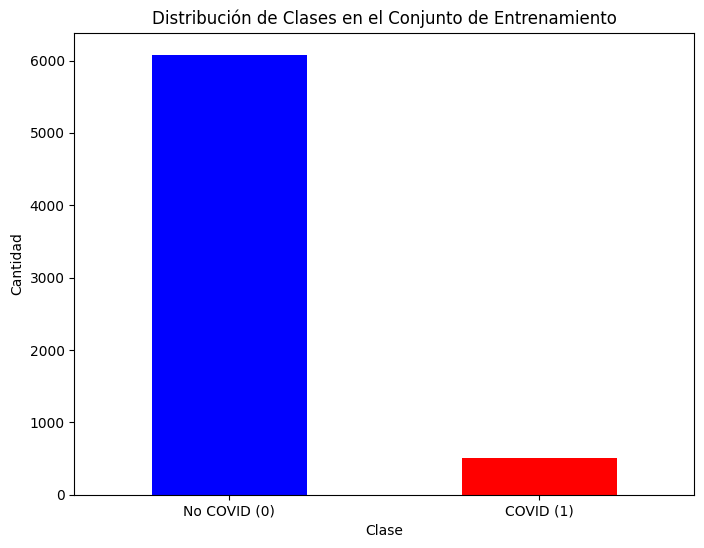

In [4]:
class_distribution = train['covid'].value_counts()

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['No COVID (0)', 'COVID (1)'], rotation=0)
plt.show()

### Procesamiento del Audio

Debido a que en la carpeta de audios, se encuentran distintos tipos de extensiones, ya sea .wav o .webm, se transforman los audios .webm a .wav debido a que esta última extensión es de mejor manejo para muchas librerías.

In [5]:
def convert_webm_to_wav(webm_path, wav_path):
    audio = AudioSegment.from_file(webm_path, format='webm')
    audio = audio.set_channels(1)  # Convert to mono
    audio.export(wav_path, format='wav')

Luego, se crea la función **process_audio_files**, la cual procesa los archivos csv que contienen los UUIDs de los audios y retorna un diccionario con las duraciones de los audios y la duración máxima encontrada. Además, implementa la función **convert_webm_to_wav** en los casos necesarios.

In [6]:
#inicializacion de variables
max_duration = 0
audio_durations = {}

In [7]:
def process_audio_files(csv_file):
    data = pd.read_csv(csv_file)
    #samples = data.drop(columns=["covid"])
    samples = data
    max_duration = 0
    audio_durations = {}
    
    for index, row in samples.iterrows():
        #print(f"INDEX {index} - Processing UUID: {row['uuid']}")
        webm_path = f'/kaggle/input/udp-dl-trabajo-3-covid-19/audio/{row["uuid"]}.webm'
        wav_path = f'/kaggle/working/{row["uuid"]}.wav'
        #print(webm_path, wav_path)
        if os.path.exists(webm_path):
            convert_webm_to_wav(webm_path, wav_path)
        elif os.path.exists(webm_path.replace('.webm', '.wav')):
            wav_path = webm_path.replace('.webm', '.wav')
        else:
            #print(f"Audio file for UUID {row['uuid']} not found.")
            continue

        duration = librosa.get_duration(path=wav_path)
        audio_durations[row['uuid']] = (wav_path, duration)
        if duration > max_duration:
            max_duration = duration
        #print(f"Duration of {row['uuid']}: {duration:.2f} seconds")
    
    return audio_durations, max_duration

In [8]:
train_audio_durations, train_max_duration = process_audio_files('/kaggle/input/udp-dl-trabajo-3-covid-19/train.csv')
test_audio_durations, test_max_duration = process_audio_files('/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv')

### Distribución de Duración de los Audios
Se muestra la distribución que tienen los tiempos de audio de train, donde es importante destacar que la duración promedio es de alrededor de 10 segundos, sin embargo, la duración máxima alcanzada es de casi 20 segundos.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


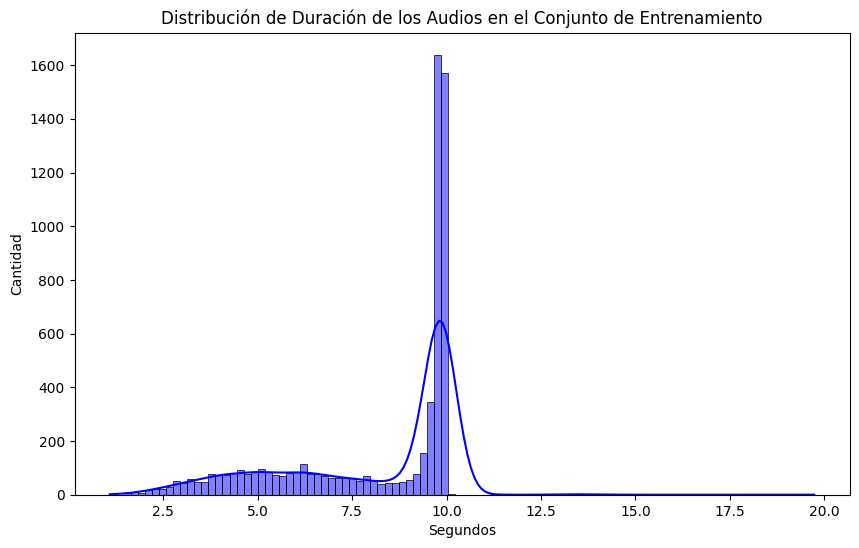

In [9]:
durations = [duration for _, (_, duration) in train_audio_durations.items()]
plt.figure(figsize=(10, 6))
sns.histplot(durations, bins=100, kde=True, color='blue')
plt.title('Distribución de Duración de los Audios en el Conjunto de Entrenamiento')
plt.xlabel('Segundos')
plt.ylabel('Cantidad')
plt.show()

### Padding a los Audios

Para poder hacer un entrenamiento con datos más consistentes, se realiza una técnica de zero-padding para normalizar todos los audios y que todos sean de una misma duración. Primero, se busca el audio mas grande (mayor duración) entre test y train para agregarle padding máss a los mas cortos, usando las variables **train_max_duration** y **test_max_duration** anteriormente creadas.

In [10]:
#aca se busca el audio mas grande entre test y train para agregarle padding despues a los mas cortos 
overall_max_duration = max(train_max_duration, test_max_duration)
print(f"Overall maximum duration: {overall_max_duration:.2f} seconds")

La función **pad_audio_files** se utiliza para agregar padding a los audios más cortos, asegurando que todos los archivos de audio tengan la misma duración. Esto se logra añadiendo ceros al final de los audios que tienen una duración menor a la duración máxima encontrada en el conjunto de datos. 

In [11]:
def pad_audio_files(audio_durations, max_duration):
    for uuid, (wav_path, duration) in audio_durations.items():
        if duration < max_duration:
            waveform, sample_rate = torchaudio.load(wav_path)
            padding = int((max_duration - duration) * sample_rate)
            padded_waveform = np.pad(waveform.numpy(), ((0, 0), (0, padding)), mode='constant')
            sf.write(wav_path, padded_waveform.T, sample_rate)
        else:
            print(f"No se necesita padding para {uuid}")

In [12]:
pad_audio_files(train_audio_durations, overall_max_duration)
pad_audio_files(test_audio_durations, overall_max_duration)

## Mel Spectogram
Debido a que trabajaremos con una CNN, necesitamos pasar los audios a "imagen", es por esto que se usa un espectograma mel, los cuales son una representación visual de un archivo de audio en el dominio de la frecuencia. Transforman la señal de audio en una serie de espectros de frecuencia que se alinean según una escala Mel, en este caso será logaritmica , la cual es una escala de frecuencia perceptualmente motivada que simula la forma en que los humanos percibimos el sonido.

In [13]:
def audio_to_mel_spectrogram(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    
    #crear el transformador de mel-espectrograma
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_mels=64
    )(waveform)
    
    #convertir a escala logarítmica
    mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)
    
    return mel_spectrogram

Se genera la función **process_and_save_mel_spectrograms** la cual genera el espectrograma por cada audio.

In [14]:
def process_and_save_mel_spectrograms(audio_durations, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for uuid, (wav_path, _) in audio_durations.items():
        try:
            mel_spectrogram = audio_to_mel_spectrogram(wav_path)
            output_path = os.path.join(output_dir, f"{uuid}.pt")
            torch.save(mel_spectrogram, output_path)
            print(f"Mel-spectrogram guardado para el audio {uuid} en {output_path}")
            
            #se elimina el archivo de audio después de procesarlo
            os.remove(wav_path)
            print(f"Audio {uuid} borrado en {wav_path}")
        except Exception as e:
            print(f"Error al procesar {uuid}: {e}")

Se generan los directorios donde serán guardados los gráficos.

In [15]:
output_dir_train = '/kaggle/working/mel_spectrograms/train'
output_dir_test = '/kaggle/working/mel_spectrograms/test'

In [16]:
process_and_save_mel_spectrograms(train_audio_durations, output_dir_train)
process_and_save_mel_spectrograms(test_audio_durations, output_dir_test)

Luego de generar los Mel Spectograms, se visualizan 3 muestras aleatorias de train.

In [17]:
def load_random_mel_spectrograms(spectrogram_dir, num_samples=3):
    all_files = [f for f in os.listdir(spectrogram_dir) if f.endswith('.pt')]
    
    random_files = random.sample(all_files, num_samples)
    
    mel_spectrograms = [torch.load(os.path.join(spectrogram_dir, f)) for f in random_files]
    
    return mel_spectrograms, random_files

In [18]:
spectrogram_dir = '/kaggle/working/mel_spectrograms/train'

In [19]:
mel_spectrograms, random_files = load_random_mel_spectrograms(spectrogram_dir, num_samples=3)

Luego, se crea una función que grafica los espectrogramas creados en dB.

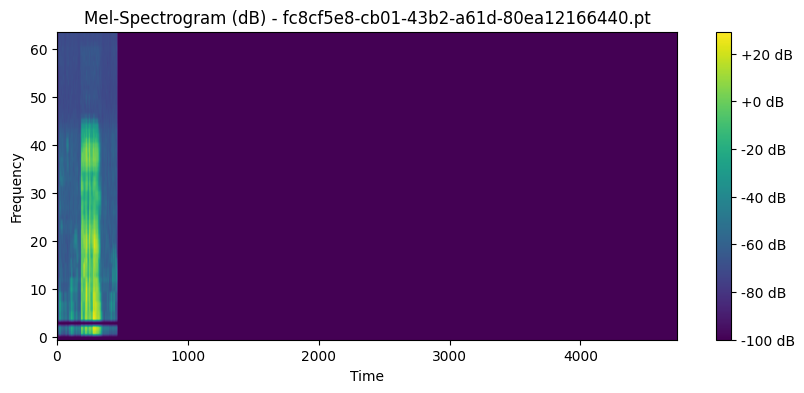

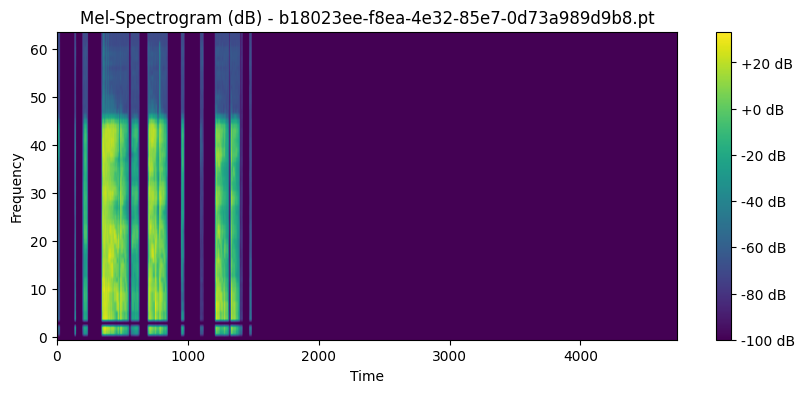

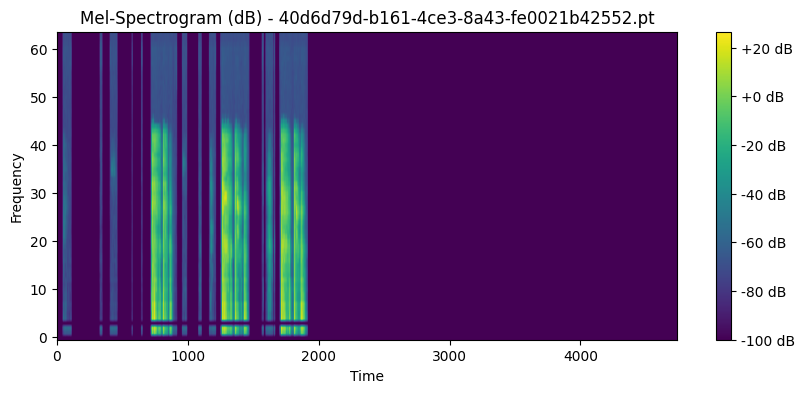

In [20]:
def plot_mel_spectrograms(mel_spectrograms, filenames):
    for i, (mel_spectrogram, filename) in enumerate(zip(mel_spectrograms, filenames)):
        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spectrogram.squeeze().numpy(), cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel-Spectrogram (dB) - {filename}')
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        plt.show()

plot_mel_spectrograms(mel_spectrograms, random_files)

## Data Augmentation

Según la distribución analizada anteriormente, se pudo notar que se contaba con muy baja presencia de clases covid. Es por esto que se decidió hacer una aumentación de datos para esa clase en particular en base a los mel generados.

Se obtienen los audios con clase covid.

In [21]:
covid_data = train[train['covid'] == 1]

Se obtiene el directorio donde están guardados los espectrogramas de train.

In [22]:
spectrogram_dir_train = spectrogram_dir

In [23]:
covid_files = [os.path.join(spectrogram_dir_train, f"{uuid}.pt") for uuid in covid_data['uuid'] if os.path.exists(os.path.join(spectrogram_dir_train, f"{uuid}.pt"))]

In [24]:
print(f"Se encontraron {len(covid_files)} COVID-19 mel-spectrograms para aumentar.")

Se encontraron 487 COVID-19 mel-spectrograms para aumentar.


Luego, se genera una clase para la aumentación la cual tiene los siguientes atributos:
- max_noise: La amplitud máxima del ruido gaussiano que se puede añadir al espectrograma.
- max_gain: El factor máximo de ganancia que se puede aplicar al espectrograma.
- Ruido gaussiano:
    - Con una probabilidad del 50% (random.random() > 0.5), se añade ruido gaussiano al espectrograma.
    - La intensidad del ruido se controla mediante max_noise.
- Ajustar ganancia:
    - Con una probabilidad del 50%, se ajusta la ganancia del espectrograma.
    - La ganancia se multiplica por un factor aleatorio entre 1.0 - max_gain y 1.0 + max_gain.

In [25]:
class MelSpectrogramAugmentation:
    def __init__(self, max_noise=0.1, max_gain=0.1):
        self.max_noise = max_noise
        self.max_gain = max_gain

    def __call__(self, mel_spectrogram):
        if random.random() > 0.5:
            mel_spectrogram = mel_spectrogram + (torch.randn_like(mel_spectrogram) * self.max_noise)
        if random.random() > 0.5:
            gain = random.uniform(1.0 - self.max_gain, 1.0 + self.max_gain)
            mel_spectrogram = mel_spectrogram * gain
        return mel_spectrogram

In [26]:
augment_transform = MelSpectrogramAugmentation()

Se guardan las aumentaciones en un factor de 7 veces para aumentar las muestras de covid.

In [27]:
augmented_dir_train = '/kaggle/working/mel_spectrograms/augmented_train'
os.makedirs(augmented_dir_train, exist_ok=True)

In [28]:
for file_path in covid_files:
    mel_spectrogram = torch.load(file_path)
    for i in range(7):  #7 augmentations
        augmented_spectrogram = augment_transform(mel_spectrogram)
        augmented_uuid = f"{os.path.splitext(os.path.basename(file_path))[0]}_aug_{i}.pt"
        augmented_path = os.path.join(augmented_dir_train, augmented_uuid)
        torch.save(augmented_spectrogram, augmented_path)
        print(f"Saved augmented mel-spectrogram at {augmented_path}")

## Entrenamiento

Se define el uso de GPU o CPU según el caso.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Se define una seed de 42 para no tener variaciones en los resultados aleatorios por las ejecuciones.

In [30]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    pl.seed_everything(seed, workers=True)
    random.seed(seed)

In [31]:
set_seed(42)

Se utiliza la transformación Normalize de torchvision.transforms para normalizar los espectrogramas Mel. Esta transformación ajusta los valores de los espectrogramas para que tengan una media de -14.0 y una desviación estándar de 17.0.

In [32]:
transform = transforms.Normalize(mean=[-14.0], std=[17.0])

Se definen los directorios con los datos para entrenar

In [33]:
spectrogram_dir_train = '/kaggle/working/mel_spectrograms/train'
augmented_dir_train = '/kaggle/working/mel_spectrograms/augmented_train'
spectrogram_dir_test = '/kaggle/working/mel_spectrograms/test'

### Dataset para entrenar

Se crea la clase MelSpectrogramDataset la cual es una implementación personalizada de Dataset de PyTorch para manejar los espectrogramas Mel. Esta clase se adapta para los datos de entrenamiento, validación o prueba, integrando tanto datos originales como aumentados.

In [34]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dirs, augmented_dir=None, test=None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.spectrogram_dirs = spectrogram_dirs
        self.augmented_dir = augmented_dir
        self.test = test
        self.transform = transform
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        file_list = []
        if not self.test:
            #añadir archivos originales y aumentados
            for spectrogram_dir in self.spectrogram_dirs:
                for uuid in self.data['uuid']:
                    file_path = os.path.join(spectrogram_dir, f"{uuid}.pt")
                    if os.path.exists(file_path):
                        label = self.data.loc[self.data['uuid'] == uuid, 'covid'].values[0]
                        file_list.append((file_path, label))

            #añadir archivos aumentados con clase 1 (COVID positivo)
            if self.augmented_dir:
                for file_name in os.listdir(self.augmented_dir):
                    if file_name.endswith(".pt"):
                        file_path = os.path.join(self.augmented_dir, file_name)
                        file_list.append((file_path, 1))  #se asigna clase 1 a todos los datos aumentados

            return file_list
        else:
            for spectrogram_dir in self.spectrogram_dirs:
                for uuid in self.data['uuid']:
                    file_path = os.path.join(spectrogram_dir, f"{uuid}.pt")
                    if os.path.exists(file_path):
                        label = -1
                        file_list.append((file_path, label))
            return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        mel_spectrogram = torch.load(file_path)
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)
        return mel_spectrogram, label

### Train, val y test

A continuación, se definen los conjuntos de train, val y test en base a la transformación y dataset creado anteriormente.

In [35]:
train_dataset = MelSpectrogramDataset(
    csv_file='/kaggle/input/udp-dl-trabajo-3-covid-19/train.csv',
    spectrogram_dirs=[spectrogram_dir_train],
    augmented_dir=augmented_dir_train,
    test = False,
    transform=transform
)

Se define un 80% para train y el otro 20% restante para validación.

In [36]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [37]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=3)

In [38]:
test_dataset = MelSpectrogramDataset(
    csv_file='/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv',
    spectrogram_dirs=[spectrogram_dir_test],
    test = True,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=3)

### Creación de CNN

Se crea la clase CoughCNN la cual es una implementación de un modelo de red neuronal convolucional (CNN) utilizando PyTorch Lightning, diseñada para esta problematica de clasificación de espectrogramas Mel de grabaciones de tos, con el fin de detectar COVID-19. A continuación, se define su estructura.
- Inicialización (init):
    - Define las capas de la red neuronal:
        - conv1 y conv2: Capas convolucionales.
        - pool: Capa de max pooling.
        - fc1 y fc2: Capas de fully connected.
        - dropout: Capa de dropout para regularización.
        - Se calcula el tamaño de entrada para la capa fully connected usando un tensor de prueba a través de las capas convolucionales y de pooling.
        - Finalmente, se define una métrica de precisión (accuracy).

- Tamaño de entrada para la capa fully connected (_initialize_fc):
    - Se pasa un tensor de prueba a través de las capas convolucionales y de pooling para determinar el tamaño de entrada de la capa fully connected.
- Método forward:
    - Se define el forward pass de la red, pasando los datos de entrada a través de las capas definidas y aplicando funciones de activación y dropout.

- Entrenamiento (training_step):
    - Calcula la pérdida de entrenamiento usando cross_entropy.
    - Se registra la pérdida de entrenamiento (train_loss) en cada época.

- Paso de validación (validation_step):
    - Se calcula la pérdida de validación y la precisión.
    - Se registra la pérdida de validación (val_loss) y la precisión de validación (val_accuracy) en cada época.

- Configuración de optimizadores (configure_optimizers):
    - Se define el optimizador Adam y un scheduler de reducción de la tasa de aprendizaje basado en la pérdida de validación (ReduceLROnPlateau).

In [39]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [40]:
class CoughCNN(pl.LightningModule):
    def __init__(self):
        super(CoughCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        #calcular el tamaño de la entrada para la capa fully connected
        self._initialize_fc()

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.3)

        self.accuracy = Accuracy(task="binary")

    def _initialize_fc(self):
        #tensor de prueba a través de las capas convolucionales y de agrupación
        with torch.no_grad():
            sample_tensor = torch.zeros(1, 1, 64, 4738)  #dimensiones del mel-spectrogram
            sample_tensor = self.pool(F.relu(self.conv1(sample_tensor)))
            sample_tensor = self.pool(F.relu(self.conv2(sample_tensor)))
            self.fc_input_size = sample_tensor.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        self.log('val_loss', loss, on_epoch=True)

        preds = torch.argmax(outputs, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('val_accuracy', acc, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }

Se crea la clase MetricsLogger la cual es un callback para PyTorch Lightning, y permite registrar y visualizar las métricas de entrenamiento y validación durante el entrenamiento de un modelo. A continuación, se define su estructura.
- Inicialización (init):
    - Se definen las listas para almacenar las métricas de train_losses, val_losses y val_accuracies.

- Registro de pérdida de entrenamiento (on_train_epoch_end):
    - Al final de cada época de entrenamiento, se obtiene la pérdida de entrenamiento del trainer y se agrega a la lista train_losses.

- Registro de métricas de validación (on_validation_epoch_end):
    - Al final de cada época de validación, se obtienen la pérdida de validación (val_loss) y la precisión de validación (val_accuracy), agregándolas a sus respectivas listas.
   
- Visualización de métricas (plot_metrics):
    - Se generan los gráficos de las pérdidas de entrenamiento y validación por época.
    - Se generan los gráficos de la precisión de validación por época.

- Impresión de tabla de métricas (print_metrics_table):
    - Se crea un dataframe con las épocas y las precisiones de validación y se imprime en formato de tabla.

In [41]:
class MetricsLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.cpu().item())
        
        val_accuracy = trainer.callback_metrics.get('val_accuracy')
        if val_accuracy is not None:
            self.val_accuracies.append(val_accuracy.cpu().item())
        
        val_preds = trainer.callback_metrics.get('val_preds')
        val_labels = trainer.callback_metrics.get('val_labels')

    def plot_metrics(self):
        if self.train_losses and self.val_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Pérdida Entrenamiento')
            plt.plot(range(1, len(self.val_losses) + 1), self.val_losses, label='Pérdida Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.title('Pérdida de Entrenamiento y Validación por Época')
            plt.legend()
            plt.show()
        if self.val_accuracies:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.val_accuracies) + 1), self.val_accuracies, label='Accuracy Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Accuracy')
            plt.title('Accuracy de Validación por Época')
            plt.legend()
            plt.show()
    def print_metrics_table(self):
        metrics_ac = pd.DataFrame({
            'Accuracy Validación': self.val_accuracies,
        })
        print(metrics_ac)

Inicialización del modelo

In [42]:
model = CoughCNN()

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#modelo
summary(model, input_size=(1, 64, 4738))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 64, 4738]             160
         MaxPool2d-2         [-1, 16, 32, 2369]               0
            Conv2d-3         [-1, 32, 32, 2369]           4,640
         MaxPool2d-4         [-1, 32, 16, 1184]               0
            Linear-5                  [-1, 128]      77,594,752
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 77,599,810
Trainable params: 77,599,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.16
Forward/backward pass size (MB): 69.40
Params size (MB): 296.02
Estimated Total Size (MB): 366.58
----------------------------------------------------------------


Inicialización de las métricas

In [44]:
metrics_logger = MetricsLogger()

Se configuran dos callbacks para el entrenamiento del modelo los cuales son Early Stopping y Model Checkpoint.
- EarlyStopping: Detiene el proceso de entrenamiento si no hay mejoras después de un número determinado de épocas para prevenir overfitting.
- Model Checkpoint: Guarda los pesos del modelo permitiendo restaurar el mejor modelo encontrado durante el entrenamiento.

In [45]:
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)

Se genera el entrenador con los parametros necesarios.

In [46]:
trainer = pl.Trainer(
    max_epochs=15,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[early_stopping, checkpoint_callback, metrics_logger]
)

Luego, se entrena el modelo.

In [47]:
trainer.fit(model, train_loader, val_loader)

2024-06-24 01:51:03.692484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 01:51:03.692591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 01:51:03.803002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Resultados

### Métricas Obtenidas

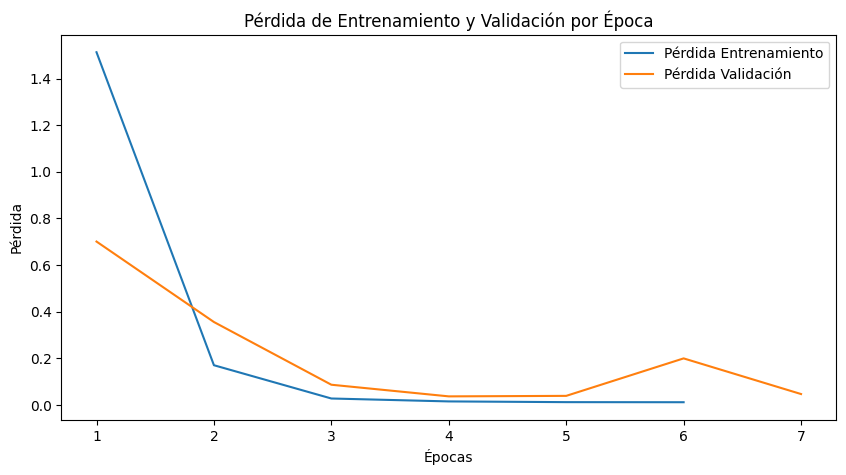

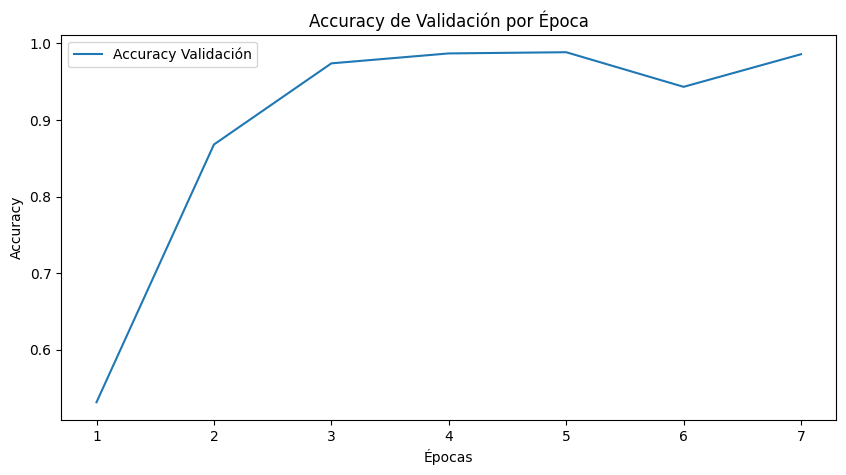

   Época
0      1
1      2
2      3
3      4
4      5
5      6
   Accuracy Validación
0             0.531250
1             0.867983
2             0.974012
3             0.987006
4             0.988566
5             0.943347
6             0.985967


In [48]:
metrics_logger.plot_metrics()
metrics_logger.print_metrics_table()

### Predicciones

Se generan las predicciones en base al modelo con mejor rendimiento.

In [49]:
model = CoughCNN.load_from_checkpoint(checkpoint_callback.best_model_path)

In [50]:
predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Debido a que los audios registrados en test.csv no existen todos en su totalidad, se genera un chequeo para reemplazar una etiqueta random en los audios no predichos.

In [51]:
test_data = pd.read_csv('/kaggle/input/udp-dl-trabajo-3-covid-19/test.csv')
uuids = test_data['uuid'].tolist()
#print(uuids)

In [52]:
uuid_to_prediction = {uuid: None for uuid in uuids}
#print(uuid_to_prediction)

In [53]:
for idx, (file_path, _) in enumerate(test_dataset.file_list):
    uuid = os.path.basename(file_path).replace('.pt', '')
    uuid_to_prediction[uuid] = predictions[idx]

In [54]:
#le doy etiqueta random a los audios que no existen
for uuid, prediction in uuid_to_prediction.items():
    if prediction is None:
        uuid_to_prediction[uuid] = np.random.randint(0, 2)

In [55]:
final_predictions = [uuid_to_prediction[uuid] for uuid in uuids]

Se crea submission para kaggle.

In [56]:
submission = pd.DataFrame({
    'ID': range(0, len(uuids)),
    'label': final_predictions
})

In [57]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [58]:
print("Predicciones guardadas en /kaggle/working/test_predictions.csv")

Predictions saved to /kaggle/working/test_predictions.csv


## Conclusiones y análisis

- Durante la validación, el modelo mostró buenos resultados, indicando que aprendió a clasificar correctamente los ejemplos dentro del conjunto de validación. Sin embargo, al evaluar el modelo en datos no vistos (test), el desempeño fue inferior.
- Esta disminución en el rendimiento se debe al gran desbalance en el dataset de entrenamiento original, donde la mayoría de las muestras eran de la clase no covid. A pesar de la aumentación de datos para la clase COVID positivo, el conjunto de datos seguía estando desbalanceado, ya que la clase no covid tenía una cantidad mayor de ejemplos y las aumentaciones se sesgaron solo para esa pequeña porción de datos.